In [1]:
import collections
import random
import numpy as np

class ReplyBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)
    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    def sample(self, batch_size):
        transition = random.sample(self.buffer, batch_size)
        # 将batch_size组state、action、reward提取出来
        state, action, reward, next_state, done = zip(*transition)
        return np.array(state), action, reward, np.array(next_state), done
    def size(self):
        return len(self.buffer)

In [2]:
import torch
import torch.nn.functional as F
class Qnet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Qnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

d:\11516\usual\anaconda\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DQN: ![](https://raw.githubusercontent.com/univwang/img/main/20221016213717.png)


Double-DQN ![](https://raw.githubusercontent.com/univwang/img/main/20221016224013.png)

In [3]:
from copy import deepcopy

class DQN:
    def __init__(self, state_dim, action_dim, hidden_dim, learning_rate, gamma, epsilon, target_update, device):
        self.model = Qnet(state_dim, hidden_dim, action_dim).to(device)
        self.target_model = deepcopy(self.model).to(device)
        self.epsilon = epsilon
        self.target_update = target_update
        self.gamma = gamma
        self.device = device
        self.action_dim = action_dim
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr = learning_rate)
        self.count = 0

    # DQN输出action
    def take_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            state = torch.tensor([state], dtype=torch.float).to(self.device)
            action = self.model(state).argmax().item()
        return action
    # DQN训练参数
    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1,1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1,1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1,1).to(self.device)

        # 核心是根据损失函数去训练
        # Q值，根据state 和 action 得出动作价值Q
        q_values = self.model(states).gather(1, actions) 

        
        target_q_values = rewards + self.gamma * self.target_model(next_states).max(1)[0].view(-1, 1) * (1 - dones)
        dqn_loss = torch.mean(F.mse_loss(q_values, target_q_values))


        self.optimizer.zero_grad()
        dqn_loss.backward()
        self.optimizer.step()

        if self.count % self.target_update == 0:
            self.target_model.load_state_dict(self.model.state_dict())

        self.count += 1



In [11]:
import gym

lr = 2e-3
num_episodes = 500 # 训练游戏的总轮数
hidden_dim = 200
gamma = 0.97 # 这是未来价值衰减
epsilon = 0.01 # 贪婪算法参数
target_update = 10 # 更新target 模型的频率
buffer_size = 10000
minimal_size = 600
batch_size = 64 # 每批训练的大小
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = "CartPole-v0"
env = gym.make(env_name)

random.seed(1)
np.random.seed(1)
torch.manual_seed(1)

d:\11516\usual\anaconda\envs\pytorch\lib\site-packages\gym\envs\registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
d:\11516\usual\anaconda\envs\pytorch\lib\site-packages\gym\core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
d:\11516\usual\anaconda\envs\pytorch\lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [12]:
replybuffer = ReplyBuffer(buffer_size)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = DQN(state_dim, action_dim, hidden_dim, lr, gamma, epsilon, target_update, device)
return_list = []

In [13]:
from tqdm import tqdm
for i in range(10):
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % (i + 1)) as pbar:
        for i_eposilon in range(int(num_episodes / 10)):
            epsode_return = 0
            state = env.reset(seed=i_eposilon)
            done = False
            while not done:
                
                action = agent.take_action(state)
                next_state, reward, done, _ = env.step(action)
                replybuffer.add(state, action, reward, next_state, done)
                state = next_state
                epsode_return += reward

                if replybuffer.size() > minimal_size:
                    b_s, b_a, b_r, b_n, b_d = replybuffer.sample(batch_size)
                    transition_dict = {
                        'states': b_s,
                        'actions': b_a,
                        'next_states': b_n,
                        'rewards': b_r,
                        'dones': b_d
                    }
                    agent.update(transition_dict)
            return_list.append(epsode_return)

            if (i_eposilon + 1) % 10 == 0:
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_eposilon + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])

                })
            pbar.update(1)

Iteration 10: 100%|██████████| 50/50 [00:07<00:00,  6.84it/s, episode=500, return=192.300]


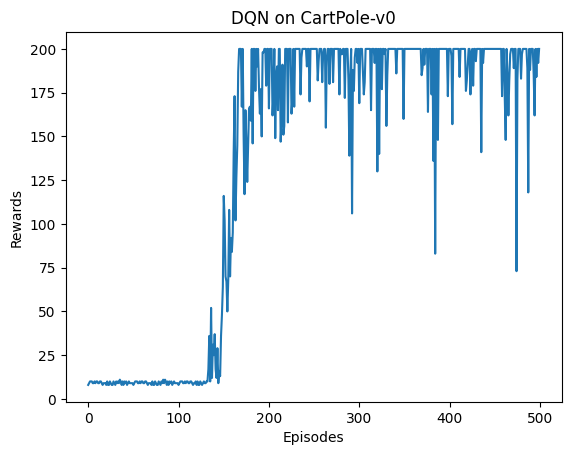

In [14]:
import matplotlib.pyplot as plt

epsilon_list = list(range(len(return_list)))
plt.plot(epsilon_list, return_list)
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.title("DQN on {}".format(env_name))
plt.show()

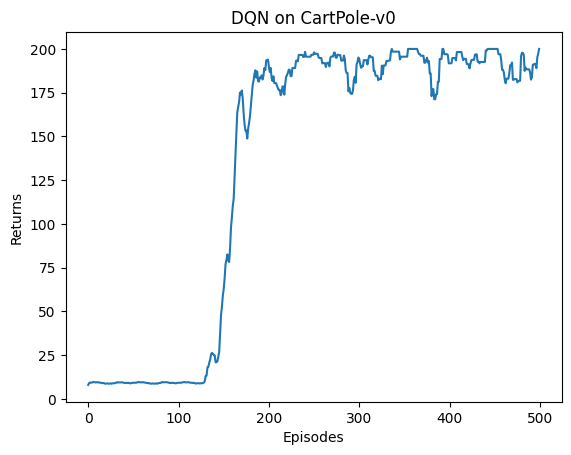

In [15]:
import rl_utils
mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(epsilon_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

In [16]:
import cv2
from matplotlib import animation 

def display_frames_as_gif(frames):
    
    patch = plt.imshow(frames[0])
    plt.axis('off')
    def animate(i):
        patch.set_data(frames[i])
   
    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=1)
    anim.save('./dqn_result.gif', writer='ffmpeg', fps=30)
    
def run_game(env):
    frames = []
    s = env.reset()
    rewards = 0
    for i_episode in range(1000):
        frames.append(env.render(mode='rgb_array'))
        # time.sleep(0.1)
        action = agent.take_action(s)
        s_, r, done, info = env.step(action)   
        s = s_
        rewards += r
        if done:  
            break
    
    display_frames_as_gif(frames)
    
    # env.close()
    return rewards


d:\11516\usual\anaconda\envs\pytorch\lib\site-packages\gym\core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


200.0


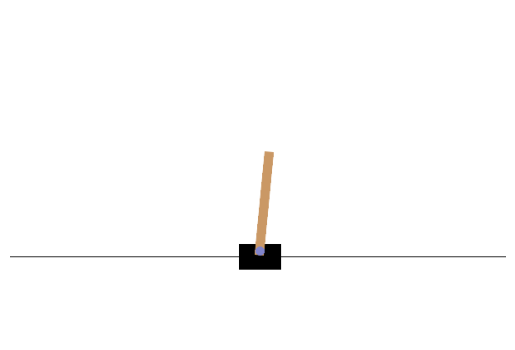

In [17]:
env.reset()
rewards = run_game(env)
print(rewards)